# Stochastic Process Simulation

This notebook covers simulation of stochastic processes with known, controllable properties.

## Topics
- **Ornstein-Uhlenbeck Process**: Mean-reverting SDE (exact + Euler-Maruyama)
- **1/f (Pink) Noise**: Long-memory noise via spectral shaping
- **Time-Varying AR (TVAR)**: AR(p) with smoothly evolving coefficients
- **Multivariate TV-VAR**: 3D VAR with rotating coupling matrices

---

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Reproducibility
rng = np.random.default_rng(42)

## 1. Ornstein-Uhlenbeck Process [VERIFIED but plot is noisier]

The OU process is a mean-reverting stochastic process defined by the SDE:

$$dx_t = -\theta (x_t - \mu) dt + \sigma dW_t$$

where:
- $\theta$ = reversion rate
- $\mu$ = long-term mean  
- $\sigma$ = noise strength
- $W_t$ = Wiener process

**Source:** `ornstein_uhlenbeck_how_to_simulate.ipynb`

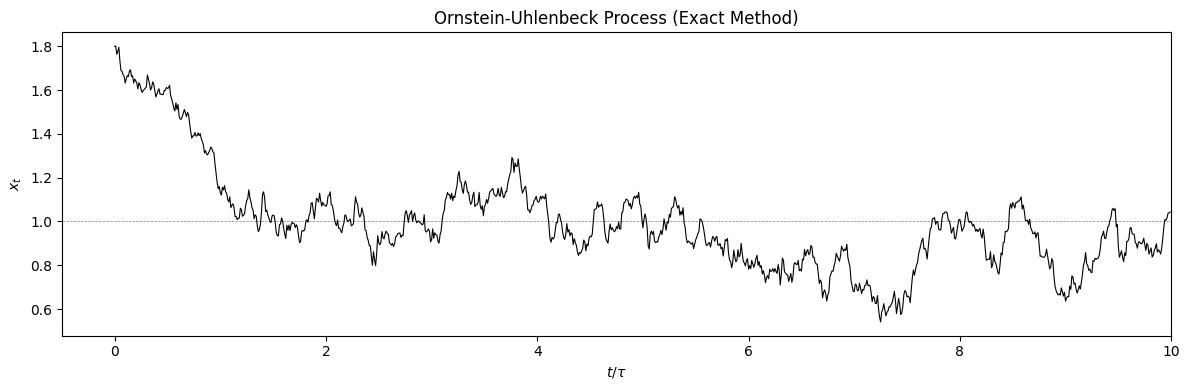

In [3]:
# -----------------------------------------------------------------------------
# Ornstein-Uhlenbeck: EXACT method
# Source: ornstein_uhlenbeck_how_to_simulate.ipynb
# -----------------------------------------------------------------------------

def simulate_ou_exact(
    n_steps: int,
    dt: float,
    theta: float = 2.0,
    mu: float = 1.0,
    sigma: float = 0.4,
    x0: float = 0.0,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate Ornstein-Uhlenbeck process using the EXACT analytical solution.
    
    The conditional distribution P(x_{t+dt} | x_t) is Gaussian with:
        mean = x_t * exp(-θ*dt) + μ * (1 - exp(-θ*dt))
        var  = σ² / (2θ) * (1 - exp(-2θ*dt))
    
    Args:
        n_steps: Number of time steps
        dt: Time step size
        theta: Reversion rate (1/theta = characteristic time scale)
        mu: Long-term mean
        sigma: Noise strength
        x0: Initial state
        seed: Random seed for reproducibility
        
    Returns:
        t: Time array of shape (n_steps,)
        x: State array of shape (n_steps,)
    """
    rng = np.random.default_rng(seed)
    
    t = np.arange(n_steps) * dt
    x = np.zeros(n_steps)
    x[0] = x0
    
    # Variance (constant, independent of current state)
    var = (sigma**2 / (2*theta)) * (1 - np.exp(-2*theta*dt))
    sd = np.sqrt(var)
    
    exp_neg_theta_dt = np.exp(-theta * dt)
    one_minus_exp = 1 - exp_neg_theta_dt
    
    for i in range(n_steps - 1):
        mean = x[i] * exp_neg_theta_dt + mu * one_minus_exp
        x[i+1] = rng.normal(loc=mean, scale=sd)
    
    return t, x


# Demo: Single trajectory
theta, mu, sigma = 2.0, 1.0, 0.4
tau = 1 / theta  # characteristic time scale
dt = 0.01 * tau
n_steps = int(10 * tau / dt)

t_ou, x_ou = simulate_ou_exact(n_steps, dt, theta, mu, sigma, x0=1.8, seed=42)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_ou / tau, x_ou, color='k', lw=0.8)
ax.axhline(mu, color='gray', ls='--', lw=0.5, zorder=-1)
ax.set_xlabel(r'$t/\tau$')
ax.set_ylabel(r'$x_t$')
ax.set_title('Ornstein-Uhlenbeck Process (Exact Method)')
ax.set_xlim(-0.5, 10)
plt.tight_layout()
plt.show()

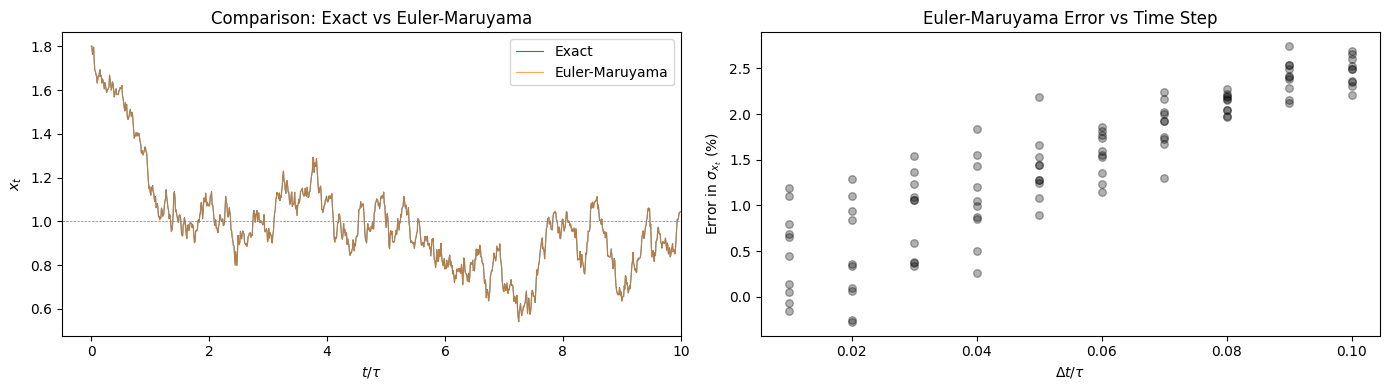

In [4]:
# -----------------------------------------------------------------------------
# Ornstein-Uhlenbeck: EULER-MARUYAMA method
# Source: ornstein_uhlenbeck_how_to_simulate.ipynb
# -----------------------------------------------------------------------------

def simulate_ou_euler_maruyama(
    n_steps: int,
    dt: float,
    theta: float = 2.0,
    mu: float = 1.0,
    sigma: float = 0.4,
    x0: float = 0.0,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate Ornstein-Uhlenbeck process using the Euler-Maruyama method.
    
    Approximation (first-order in dt):
        x_{t+dt} ≈ x_t - θ*dt*(x_t - μ) + σ*sqrt(dt)*ε
    
    Args:
        n_steps: Number of time steps
        dt: Time step size  
        theta: Reversion rate
        mu: Long-term mean
        sigma: Noise strength
        x0: Initial state
        seed: Random seed
        
    Returns:
        t: Time array of shape (n_steps,)
        x: State array of shape (n_steps,)
    """
    rng = np.random.default_rng(seed)
    
    t = np.arange(n_steps) * dt
    x = np.zeros(n_steps)
    x[0] = x0
    
    # Euler-Maruyama: variance ≈ σ²*dt (first-order approx)
    sd = sigma * np.sqrt(dt)
    
    for i in range(n_steps - 1):
        mean = x[i] - theta * dt * (x[i] - mu)
        x[i+1] = rng.normal(loc=mean, scale=sd)
    
    return t, x


# Compare Exact vs Euler-Maruyama
t_em, x_em = simulate_ou_euler_maruyama(n_steps, dt, theta, mu, sigma, x0=1.8, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(t_ou / tau, x_ou, lw=0.8, label='Exact')
axes[0].plot(t_em / tau, x_em, lw=0.8, alpha=0.7, label='Euler-Maruyama')
axes[0].axhline(mu, color='gray', ls='--', lw=0.5)
axes[0].set_xlabel(r'$t/\tau$')
axes[0].set_ylabel(r'$x_t$')
axes[0].set_title('Comparison: Exact vs Euler-Maruyama')
axes[0].legend()
axes[0].set_xlim(-0.5, 10)

# Error analysis: Euler-Maruyama error vs dt
dt_values = tau * np.linspace(0.01, 0.1, 10)
n_repeats = 10
n_long = int(1e6)

errors = []
for dt_test in dt_values:
    for _ in range(n_repeats):
        _, x_test = simulate_ou_euler_maruyama(n_long, dt_test, theta, mu, sigma, x0=0, seed=None)
        sd_hat = np.std(x_test)
        sd_exact = sigma / np.sqrt(2 * theta)
        error_pct = 100 * (sd_hat - sd_exact) / sd_exact
        errors.append((dt_test / tau, error_pct))

errors = np.array(errors)
axes[1].scatter(errors[:, 0], errors[:, 1], c='k', s=30, alpha=0.3)
axes[1].set_xlabel(r'$\Delta t / \tau$')
axes[1].set_ylabel(r'Error in $\sigma_{x_t}$ (%)')
axes[1].set_title('Euler-Maruyama Error vs Time Step')

plt.tight_layout()
plt.show()

## 2. Colored Noise (1/f and White Noise) [VERIFIED]

Generate noise with controlled spectral properties:
- **White noise**: Flat PSD, no temporal correlation
- **1/f (pink) noise**: PSD ∝ 1/f^α, long-range correlations

**Source:** `1overf_sim.ipynb`

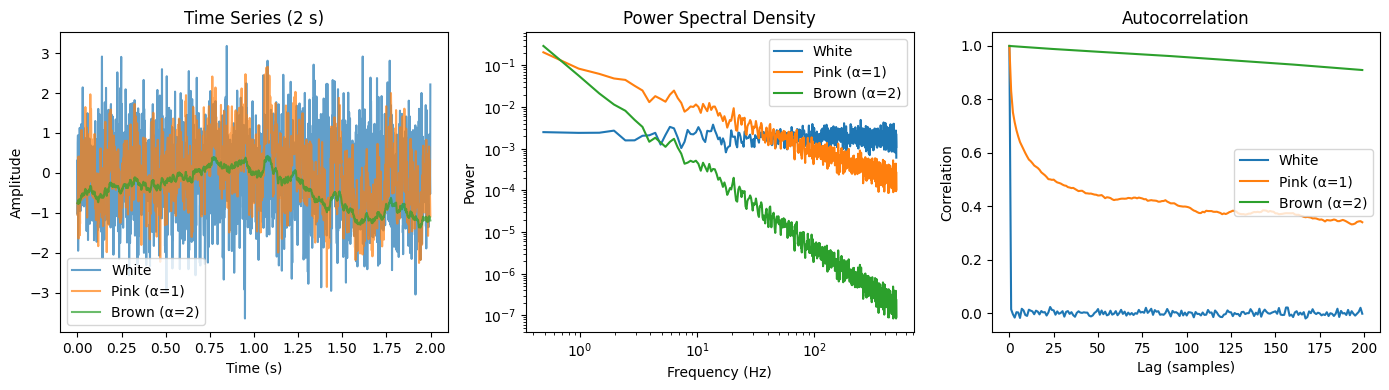

In [5]:
# -----------------------------------------------------------------------------
# White Noise Generator
# Source: 1overf_sim.ipynb
# -----------------------------------------------------------------------------

def make_white_noise(n: int, seed: int | None = None) -> np.ndarray:
    """
    Generate standard white noise (Gaussian, i.i.d.).
    
    Args:
        n: Number of samples
        seed: Random seed
        
    Returns:
        x: White noise array of shape (n,), zero mean, unit variance
    """
    rng = np.random.default_rng(seed)
    return rng.standard_normal(n)


# -----------------------------------------------------------------------------
# 1/f (Pink) Noise Generator via Spectral Shaping
# Source: 1overf_sim.ipynb
# -----------------------------------------------------------------------------

def make_1_over_f_noise(
    n: int, 
    fs: float = 1.0, 
    alpha: float = 1.0, 
    seed: int | None = None
) -> np.ndarray:
    """
    Generate 1/f^α noise via spectral shaping.
    
    Method: Generate white noise in frequency domain, scale magnitudes by 1/f^(α/2),
    then inverse FFT back to time domain.
    
    Args:
        n: Number of samples
        fs: Sampling frequency (Hz)
        alpha: Spectral exponent (α=1 for pink, α=2 for brown/red)
        seed: Random seed
        
    Returns:
        x: Colored noise array of shape (n,), standardized to zero mean, unit variance
    """
    rng = np.random.default_rng(seed)
    
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    
    # Random complex spectrum (white noise in freq domain)
    re = rng.standard_normal(freqs.shape)
    im = rng.standard_normal(freqs.shape)
    X = re + 1j * im
    
    # Shape magnitude: 1/f^(alpha/2) so PSD ∝ 1/f^alpha
    mag_shape = np.ones_like(freqs)
    mag_shape[1:] = 1.0 / (freqs[1:] ** (alpha / 2.0))
    mag_shape[0] = 0.0  # Zero DC component
    
    X = X * mag_shape
    x = np.fft.irfft(X, n=n)
    
    # Standardize
    x = (x - np.mean(x)) / np.std(x)
    return x


# Demo: Compare white vs 1/f noise
n = 12000
fs = 1000.0
seed = 42

x_white = make_white_noise(n, seed=seed)
x_pink = make_1_over_f_noise(n, fs=fs, alpha=1.0, seed=seed)
x_brown = make_1_over_f_noise(n, fs=fs, alpha=2.0, seed=seed)

# Compute PSDs
f_w, Pxx_w = welch(x_white, fs=fs, nperseg=2048)
f_p, Pxx_p = welch(x_pink, fs=fs, nperseg=2048)
f_b, Pxx_b = welch(x_brown, fs=fs, nperseg=2048)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Time series
t = np.arange(2000) / fs
axes[0].plot(t, x_white[:2000], alpha=0.7, label='White')
axes[0].plot(t, x_pink[:2000], alpha=0.7, label='Pink (α=1)')
axes[0].plot(t, x_brown[:2000], alpha=0.7, label='Brown (α=2)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Time Series (2 s)')
axes[0].legend()

# PSD
axes[1].loglog(f_w[1:], Pxx_w[1:], label='White')
axes[1].loglog(f_p[1:], Pxx_p[1:], label='Pink (α=1)')
axes[1].loglog(f_b[1:], Pxx_b[1:], label='Brown (α=2)')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power')
axes[1].set_title('Power Spectral Density')
axes[1].legend()

# Autocorrelation
def autocorr(x, max_lag):
    x = x - np.mean(x)
    ac = np.correlate(x, x, mode="full")
    ac = ac[ac.size // 2:]
    return (ac / ac[0])[:max_lag]

max_lag = 200
axes[2].plot(autocorr(x_white, max_lag), label='White')
axes[2].plot(autocorr(x_pink, max_lag), label='Pink (α=1)')
axes[2].plot(autocorr(x_brown, max_lag), label='Brown (α=2)')
axes[2].set_xlabel('Lag (samples)')
axes[2].set_ylabel('Correlation')
axes[2].set_title('Autocorrelation')
axes[2].legend()

plt.tight_layout()
plt.show()

## 3. Time-Varying AR (TVAR) — Univariate [VERIFIED]

AR(p) process where coefficients $a_i(t)$ evolve smoothly over time:

$$x_t = \sum_{i=1}^{p} a_i(t) \cdot x_{t-i} + \varepsilon_t$$

We implement two variants:
1. **Sinusoidal coefficients**: Each $a_i(t) = A_i \sin(2\pi f_i t + \phi_i)$
2. **Parametric coefficients**: Base + amplitude × sinusoid

**Sources:** `TimeVariying_AR_Simualtion.ipynb`, `tvar_linear_mlp.ipynb`

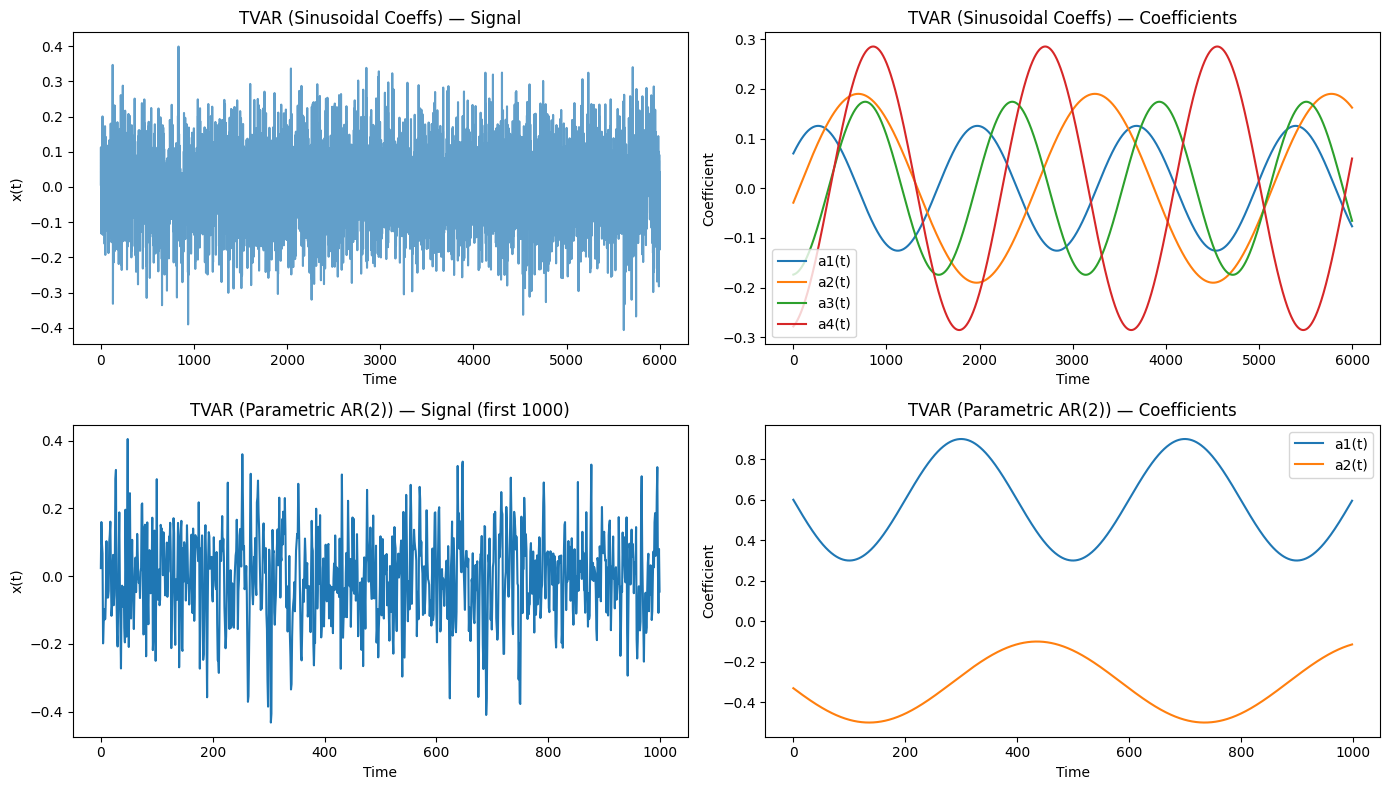

In [6]:
# -----------------------------------------------------------------------------
# TVAR Variant 1: Sinusoidal Coefficients (Random frequencies/phases)
# Source: tvar_linear_mlp.ipynb
# -----------------------------------------------------------------------------

def simulate_tvar_sinusoidal(
    n: int = 6000,
    p: int = 3,
    noise_std: float = 0.1,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate TVAR data where coefficients evolve as sine waves.
    Each lag coefficient has its own random frequency and phase.
    
    Args:
        n: Number of samples
        p: AR order (number of lags)
        noise_std: Innovation noise standard deviation
        seed: Random seed
        
    Returns:
        x: Time series of shape (n,)
        a_time: Coefficient matrix of shape (n, p) — a_time[t, i] = a_{i+1}(t)
        t_arr: Time indices
    """
    rng = np.random.default_rng(seed)
    t_arr = np.arange(n)
    
    # Random sinusoidal parameters for each lag
    freqs = rng.uniform(0.001, 0.005, size=p) / 7  # Slow evolution
    phases = rng.uniform(0, 2*np.pi, size=p)
    scales = rng.uniform(0.1, 0.3, size=p)  # Small to ensure stability
    
    # Build coefficient matrix
    a_time = np.zeros((n, p))
    for i in range(p):
        a_time[:, i] = scales[i] * np.sin(2*np.pi * freqs[i] * t_arr + phases[i])
    
    # Simulate AR process
    x = np.zeros(n)
    eps = rng.normal(0.0, noise_std, size=n)
    x[:p] = eps[:p]
    
    for t in range(p, n):
        lags = x[t-p:t][::-1]  # [x_{t-1}, x_{t-2}, ..., x_{t-p}]
        x[t] = np.dot(a_time[t], lags) + eps[t]
        
        # Stability check
        if np.abs(x[t]) > 1000:
            print(f"Warning: Signal exploded at t={t}")
            break
    
    return x, a_time, t_arr


# -----------------------------------------------------------------------------
# TVAR Variant 2: Parametric Sinusoidal Coefficients
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

def simulate_tvar_parametric(
    T: int = 3000,
    a1_base: float = 0.6, a1_amp: float = 0.3, a1_period: int = 400, a1_phase: float = 0.0,
    a2_base: float = -0.3, a2_amp: float = 0.2, a2_period: int = 600, a2_phase: float = 1.2,
    noise_std: float = 0.1,
    burn_in: int = 200,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate univariate TV-AR(2) with parametric sinusoidal coefficients.
    
    a1(t) = a1_base + a1_amp * sin(2π*t/a1_period + a1_phase)
    a2(t) = a2_base + a2_amp * sin(2π*t/a2_period + a2_phase)
    
    Args:
        T: Number of output samples (after burn-in)
        a1_base, a1_amp, a1_period, a1_phase: Parameters for first coefficient
        a2_base, a2_amp, a2_period, a2_phase: Parameters for second coefficient
        noise_std: Innovation noise std
        burn_in: Number of samples to discard
        seed: Random seed
        
    Returns:
        x: Time series of shape (T,)
        a1: First AR coefficient over time, shape (T,)
        a2: Second AR coefficient over time, shape (T,)
    """
    rng = np.random.default_rng(seed)
    T_total = T + burn_in
    t = np.arange(T_total)
    
    a1 = a1_base + a1_amp * np.sin(2*np.pi * t / a1_period + a1_phase)
    a2 = a2_base + a2_amp * np.sin(2*np.pi * t / a2_period + a2_phase)
    
    x = np.zeros(T_total)
    eps = rng.normal(0.0, noise_std, size=T_total)
    
    for k in range(2, T_total):
        x[k] = a1[k] * x[k-1] + a2[k] * x[k-2] + eps[k]
    
    return x[burn_in:], a1[burn_in:], a2[burn_in:]


# Demo: Both TVAR variants
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Variant 1: Sinusoidal
x_sin, a_sin, t_sin = simulate_tvar_sinusoidal(n=6000, p=4, seed=42)
axes[0, 0].plot(t_sin, x_sin, alpha=0.7)
axes[0, 0].set_title('TVAR (Sinusoidal Coeffs) — Signal')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('x(t)')

for i in range(a_sin.shape[1]):
    axes[0, 1].plot(t_sin, a_sin[:, i], label=f'a{i+1}(t)')
axes[0, 1].set_title('TVAR (Sinusoidal Coeffs) — Coefficients')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Coefficient')
axes[0, 1].legend()

# Variant 2: Parametric
x_par, a1_par, a2_par = simulate_tvar_parametric(T=4000, seed=42)
axes[1, 0].plot(x_par[:1000])
axes[1, 0].set_title('TVAR (Parametric AR(2)) — Signal (first 1000)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('x(t)')

axes[1, 1].plot(a1_par[:1000], label='a1(t)')
axes[1, 1].plot(a2_par[:1000], label='a2(t)')
axes[1, 1].set_title('TVAR (Parametric AR(2)) — Coefficients')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Coefficient')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Multivariate Time-Varying VAR (TV-VAR)

3D VAR(2) process with **rotating coupling matrices** to ensure stability:

$$\mathbf{X}_t = A_1(t) \mathbf{X}_{t-1} + A_2(t) \mathbf{X}_{t-2} + \boldsymbol{\varepsilon}_t$$

where $A_i(t) = R(t) \cdot \text{diag}(\lambda) \cdot R(t)^T$ with orthogonal rotation $R(t)$.

This ensures eigenvalues remain fixed (stable) while the coupling structure rotates over time.

**Source:** `TimeVariying_AR_Simualtion.ipynb`

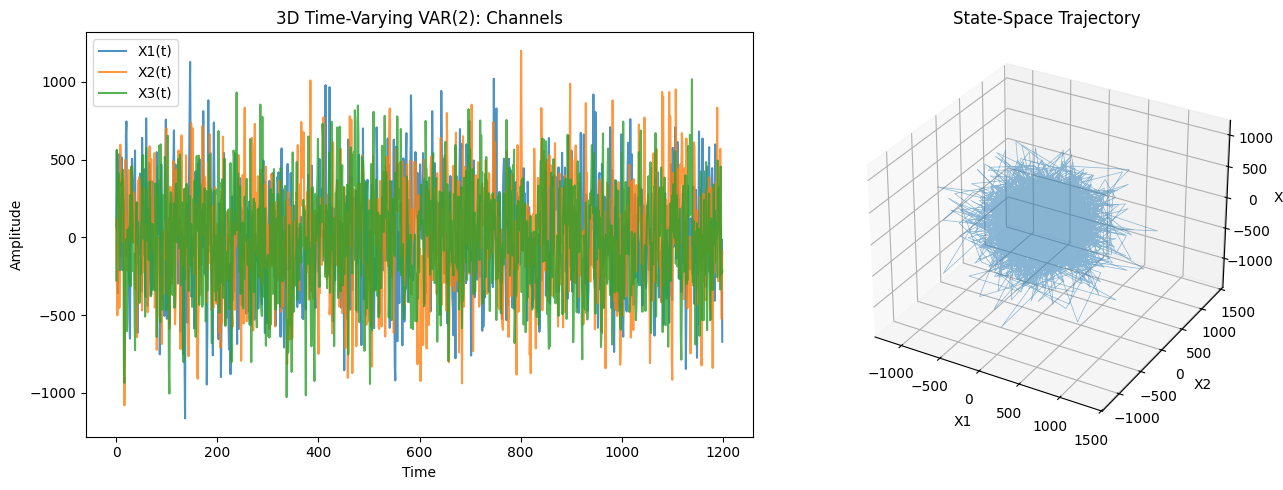

Eigenvalues (A1): [0.45 0.35 0.3 ]
Eigenvalues (A2): [-0.1  -0.08 -0.06]


In [7]:
# -----------------------------------------------------------------------------
# 3D Rotation Matrices
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

def Rz(theta: float) -> np.ndarray:
    """Rotation matrix around z-axis."""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, -s, 0.0],
        [s,  c, 0.0],
        [0.0, 0.0, 1.0]
    ])

def Ry(theta: float) -> np.ndarray:
    """Rotation matrix around y-axis."""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [ c, 0.0,  s],
        [0.0, 1.0, 0.0],
        [-s, 0.0,  c]
    ])


# -----------------------------------------------------------------------------
# 3D Time-Varying VAR(2) with Rotating Coupling Matrices
# Source: TimeVariying_AR_Simualtion.ipynb
# -----------------------------------------------------------------------------

def simulate_tvvar3_stable(
    T: int = 4000,
    burn_in: int = 300,
    noise_cov: np.ndarray | None = None,
    alpha: np.ndarray | None = None,
    beta: np.ndarray | None = None,
    seed: int | None = None
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    3D time-varying VAR(2) with smoothly rotating coupling matrices.
    
    Ensures stability by:
    - Using orthogonal rotation matrices R(t)
    - Keeping eigenvalues fixed: A = R @ diag(λ) @ R.T
    - Spectral radius < 1
    
    Args:
        T: Number of output samples (after burn-in)
        burn_in: Number of samples to discard for transient
        noise_cov: 3x3 innovation covariance matrix
        alpha: 3-vector of eigenvalues for A1 (first lag)
        beta: 3-vector of eigenvalues for A2 (second lag, negative for damping)
        seed: Random seed
        
    Returns:
        X: Multivariate time series of shape (T, 3)
        alpha: First-lag eigenvalues used
        beta: Second-lag eigenvalues used
    """
    rng = np.random.default_rng(seed)
    
    if noise_cov is None:
        noise_cov = 100000 * np.eye(3)
    L = np.linalg.cholesky(noise_cov)
    
    # Stable diagonal eigenvalues
    if alpha is None:
        alpha = np.array([0.45, 0.35, 0.30])  # first-lag magnitudes
    if beta is None:
        beta = np.array([-0.10, -0.08, -0.06])  # negative helps damping
    
    def angles(k):
        th1 = 2*np.pi * k / 500.0
        th2 = 2*np.pi * k / 900.0 + 0.7
        return th1, th2
    
    T_total = T + burn_in
    X = np.zeros((T_total, 3))
    eps = rng.normal(size=(T_total, 3)) @ L.T
    
    for k in range(2, T_total):
        th1, th2 = angles(k)
        
        # Time-varying rotation matrices
        R1 = Rz(th1) @ Ry(th1 * 0.5)
        R2 = Ry(th2) @ Rz(th2 * 0.5)
        
        # A = R @ diag(eigenvalues) @ R.T ensures eigenvalues are preserved
        A1 = R1 @ np.diag(alpha) @ R1.T
        A2 = R2 @ np.diag(beta) @ R2.T
        
        X[k] = A1 @ X[k-1] + A2 @ X[k-2] + eps[k]
    
    return X[burn_in:], alpha, beta


# Demo: 3D TV-VAR
X3, alpha_used, beta_used = simulate_tvvar3_stable(T=4000, seed=42)

fig = plt.figure(figsize=(14, 5))

# Time series
ax1 = fig.add_subplot(1, 2, 1)
for i in range(3):
    ax1.plot(X3[:1200, i], label=f'X{i+1}(t)', alpha=0.8)
ax1.set_title('3D Time-Varying VAR(2): Channels')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.legend()

# 3D state-space trajectory
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(X3[:2500, 0], X3[:2500, 1], X3[:2500, 2], 
         linewidth=0.5, alpha=0.5)
ax2.set_title('State-Space Trajectory')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('X3')

plt.tight_layout()
plt.show()

print(f"Eigenvalues (A1): {alpha_used}")
print(f"Eigenvalues (A2): {beta_used}")

---

## Summary: All Simulation Functions

| Function | Description | Source |
|----------|-------------|--------|
| `simulate_ou_exact()` | OU process (exact solution) | `ornstein_uhlenbeck_how_to_simulate.ipynb` |
| `simulate_ou_euler_maruyama()` | OU process (Euler-Maruyama approx) | `ornstein_uhlenbeck_how_to_simulate.ipynb` |
| `make_white_noise()` | White Gaussian noise | `1overf_sim.ipynb` |
| `make_1_over_f_noise()` | 1/f^α colored noise | `1overf_sim.ipynb` |
| `simulate_tvar_sinusoidal()` | TVAR with random sinusoidal coeffs | `tvar_linear_mlp.ipynb` |
| `simulate_tvar_parametric()` | TVAR(2) with parametric sinusoids | `TimeVariying_AR_Simualtion.ipynb` |
| `simulate_tvvar3_stable()` | 3D TV-VAR(2) with rotating matrices | `TimeVariying_AR_Simualtion.ipynb` |

**Helper functions:** `Rz()`, `Ry()`, `autocorr()`